In [30]:
import kagglehub

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [33]:

# Step 2: Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


# Exploratory Data Analysis

In [45]:
# Step 3: Load the dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()
print(df.isnull().sum().sum())

0


In [6]:
# Step 4: Explore the dataset
print(df.info())
print(df.shape)
print(df.describe())
print("Class distribution:\n", df['Class'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Class distribution

##### Class 0: 284315 samples (99.8%)
#### Class 1: 492 samples (0.2%)

In [53]:
# Count and calculate percentage
count = df['Class'].value_counts()
percent = df['Class'].value_counts(normalize=True) * 100


#Plot a pie chart to show the distribution
labels=["Genuine","Fraud"]

fraud_or_not = df["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

plot = px.pie(values=df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["lightgreen","black"]
             ,title="Distribution of Classes (0 = Genuine, 1 = Fraud)")
plot.show()




# Data Cleaning

#### No missing values are present in the dataset.

In [54]:
print(df.isnull().sum().sum())

0


#### This shows in total of `1081` rows have identical or duplicate values.


*   In a highly imbalanced dataset, duplicate legitimate transactions (Class = 0) can worsen the imbalance.

*   Duplicate fraudulent rows (Class = 1) can cause overfitting in models — the model might "memorize" those rows.

Hence in addition to null value rows it is important to remove the duplicate rows also.

In [55]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
duplicates = df[df.duplicated()]


Number of duplicate rows: 1081


In [56]:
# Remove duplicates
df = df.drop_duplicates()

# Remove NaN
df = df.dropna(subset=['Class'])


In [57]:
print('Number of duplicates: ',df.duplicated().sum())
print('Number of missing values: ',df.isnull().sum().sum())

Number of duplicates:  0
Number of missing values:  0


# Preprocessing

Since the other columns are already PCA (Principal Component Analysis) transformed by the creators of the dataset to anonymize sensitive data (like original transaction details) we only normalize the `Time` and `Amount` columns

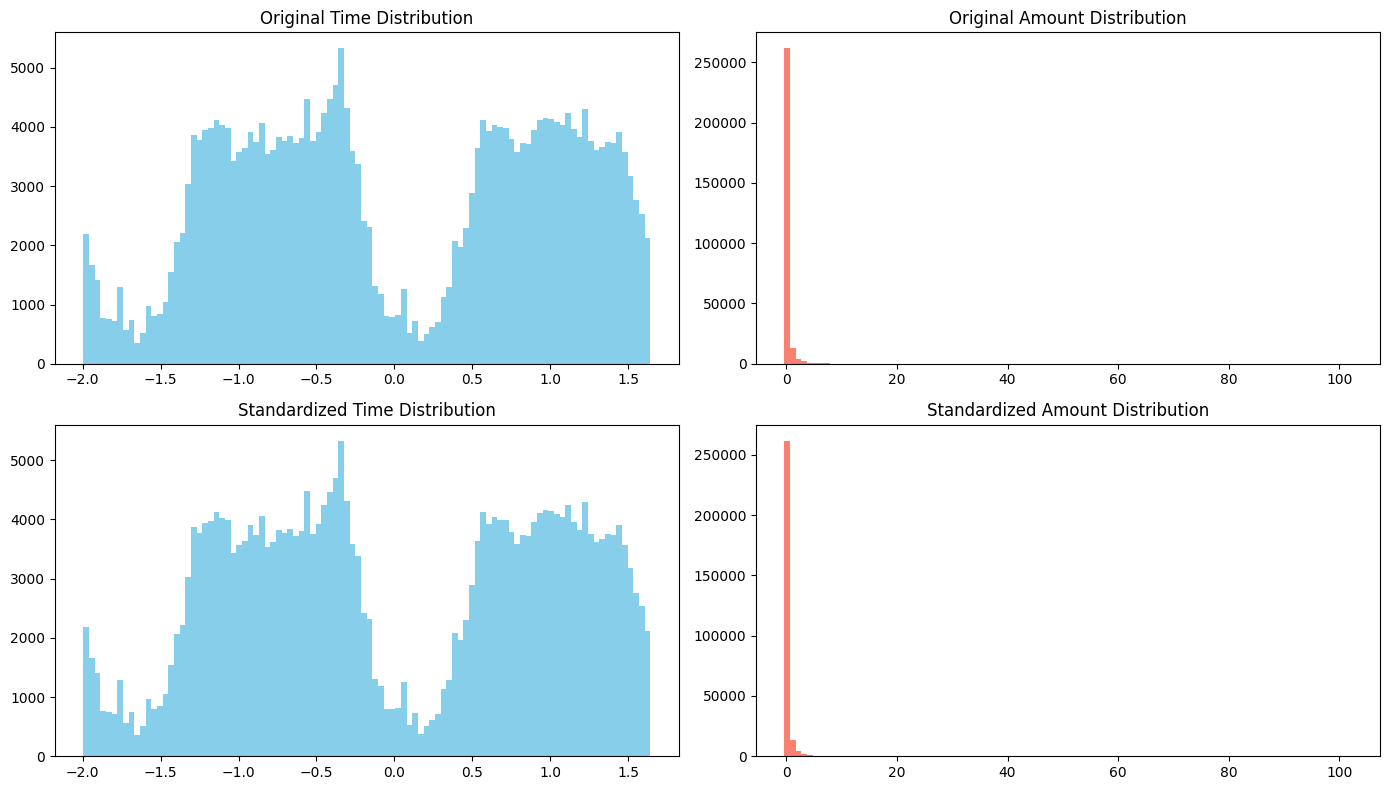

In [60]:

# Save original values for comparison
time_orig = df['Time'].copy()
amount_orig = df['Amount'].copy()

# Normalize Time and Amount
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

# Plot before and after side-by-side
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original Time
axes[0, 0].hist(time_orig, bins=100, color='skyblue')
axes[0, 0].set_title('Original Time Distribution')

# Original Amount
axes[0, 1].hist(amount_orig, bins=100, color='salmon')
axes[0, 1].set_title('Original Amount Distribution')

# Normalized Time
axes[1, 0].hist(df['Time'], bins=100, color='skyblue')
axes[1, 0].set_title('Standardized Time Distribution')

# Normalized Amount
axes[1, 1].hist(df['Amount'], bins=100, color='salmon')
axes[1, 1].set_title('Standardized Amount Distribution')

plt.tight_layout()
plt.show()

| Step                | Action Taken                               |
| ------------------- | ------------------------------------------ |
| Missing Values      | Checked and dropped or filled if any       |
| Duplicates          | Removed duplicate rows                     |
| Normalization       | Scaled `Amount` and `Time`                 |
| Data Types          | Verified using `.info()`                   |
| Target Distribution | Counted and printed class labels (0 and 1) |


# Split the dataset

In [61]:
X = df.drop('Class', axis=1)
y = df['Class']

# Split first
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (226980, 30), Test shape: (56746, 30)


The credit card fraud dataset is highly imbalanced, with fraudulent transactions (Class=1) making up less than 1% of all records. This imbalance causes most models to be biased toward the majority class (Class=0), leading to poor fraud detection. SMOTE generates synthetic minority class samples to balance the training data, helping models learn better decision boundaries and improve fraud detection performance without simply duplicating data.

# SMOTE on training data to address the imbalance in the `Class` feature

In [62]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

According to this paper https://ieeexplore.ieee.org/document/10397696 KNN has the highest accuracy, followed by Random Forest Classifier and Logistic Regression. Hence I chose these in addition to that XGBoost was used in recent papers in 2025. I would like to compare the performance of these 3 models

In [63]:

# Check new class distribution
print("After Resampling:")
print("Class 0:", sum(y_train_resampled == 0))
print("Class 1:", sum(y_train_resampled == 1))

After Resampling:
Class 0: 226602
Class 1: 226602


**Justification and Working Principle**

* Logistic Regression


Why: Fast, interpretable baseline model.

Working: Predicts the probability of fraud using a linear decision boundary and a sigmoid function. Ideal for binary classification tasks.

*  K-Nearest Neighbors (KNN)
Why: Simple and effective for small to medium-sized datasets.

Working: Classifies a transaction based on the majority label among its k nearest neighbors in the feature space.
*  Random Forest Classifier
Why: Handles non-linear data well and is robust to overfitting.

Working: An ensemble of decision trees where each tree votes. Uses bootstrapped samples and feature randomness for diversity.

*  XGBoost Classifier
Why: High accuracy and handles imbalanced data well.

Working: Builds decision trees sequentially, where each new tree corrects errors from the previous ones. Includes regularization and is optimized for speed and performance.



# Logistic Regression

=== Logistic Regression ===
Confusion Matrix:
 [[56641    10]
 [   39    56]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.85      0.59      0.70        95

    accuracy                           1.00     56746
   macro avg       0.92      0.79      0.85     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix for RandomForest:
[[56641    10]
 [   39    56]]


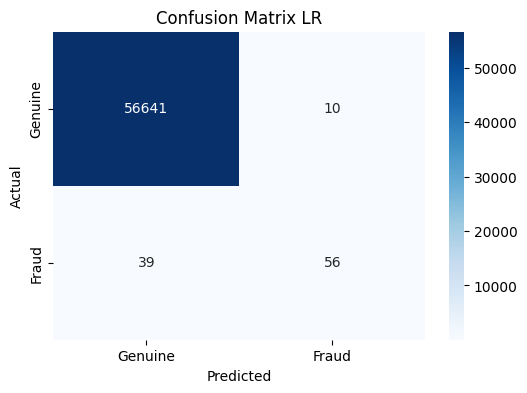

In [47]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:, 1]
log_cm = confusion_matrix(y_test, log_preds)

print("Logistic Regression")
print("Confusion Matrix:\n", log_cm)
print("\nClassification Report:\n", classification_report(y_test, log_preds))
log_auc = roc_auc_score(y_test, log_probs)
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
print("Confusion Matrix for RandomForest:")
print(log_cm)

#Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix LR')
plt.show()


# K Nearest Neighbours

=== K-Nearest Neighbors ===
Confusion Matrix:
 [[56649     2]
 [   28    67]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.71      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746



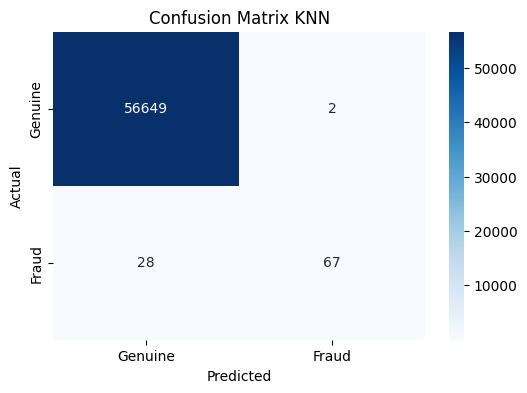

In [49]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
knn_probs = knn_model.predict_proba(X_test)[:, 1]
knn_cm = confusion_matrix(y_test, knn_preds)

print("K-Nearest Neighbors")
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_preds))
print("\nClassification Report:\n", classification_report(y_test, knn_preds))

knn_auc = roc_auc_score(y_test, knn_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix KNN')
plt.show()


# Random Forest

=== Random Forest ===
Confusion Matrix:
 [[56649     2]
 [   27    68]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.72      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746



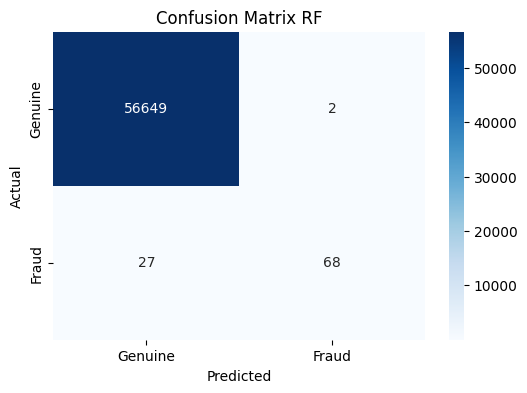

In [51]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_cm = confusion_matrix(y_test, rf_preds)
print("Random Forest")
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))
print("\nClassification Report:\n", classification_report(y_test, rf_preds))

rf_auc = roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

#Plot confusion matix
plt.figure(figsize=(6,4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix RF')
plt.show()

# XGBoost

=== XGBoost ===
Confusion Matrix:
 [[56648     3]
 [   24    71]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.96      0.75      0.84        95

    accuracy                           1.00     56746
   macro avg       0.98      0.87      0.92     56746
weighted avg       1.00      1.00      1.00     56746



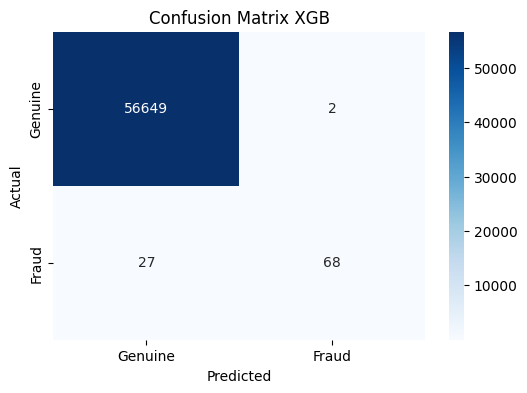

In [64]:
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_cm = confusion_matrix(y_test, xgb_preds)
print("XGBoost")
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds))
print("\nClassification Report:\n", classification_report(y_test, xgb_preds))

xgb_auc = roc_auc_score(y_test, xgb_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(6,4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix XGB')
plt.show()



# ROC

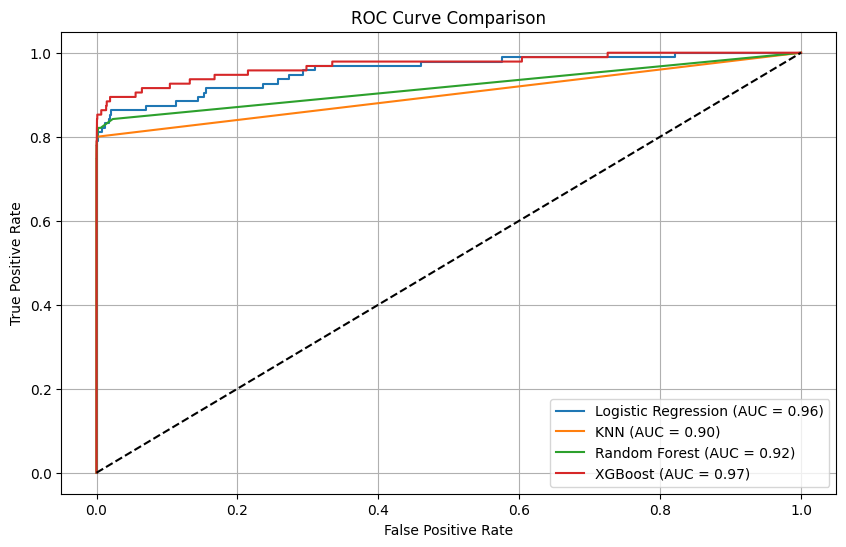

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(log_fpr, log_tpr, label=f"Logistic Regression (AUC = {log_auc:.2f})")
plt.plot(knn_fpr, knn_tpr, label=f"KNN (AUC = {knn_auc:.2f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


# Performance Summary

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression
log_acc = accuracy_score(y_test, log_preds)
log_prec = precision_score(y_test, log_preds)
log_rec = recall_score(y_test, log_preds)
log_f1 = f1_score(y_test, log_preds)
log_auc = roc_auc_score(y_test, log_probs)

# KNN
knn_acc = accuracy_score(y_test, knn_preds)
knn_prec = precision_score(y_test, knn_preds)
knn_rec = recall_score(y_test, knn_preds)
knn_f1 = f1_score(y_test, knn_preds)
knn_auc = roc_auc_score(y_test, knn_probs)

# Random Forest
rf_acc = accuracy_score(y_test, rf_preds)
rf_prec = precision_score(y_test, rf_preds)
rf_rec = recall_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_auc = roc_auc_score(y_test, rf_probs)

# XGBoost
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_prec = precision_score(y_test, xgb_preds)
xgb_rec = recall_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)
xgb_auc = roc_auc_score(y_test, xgb_probs)


In [70]:
print("Model Performance Metrics\n")
print(f"Logistic Regression  -> Accuracy: {log_acc:.4f}, Precision: {log_prec:.4f}, Recall: {log_rec:.4f}, F1 Score: {log_f1:.4f}, ROC AUC: {log_auc:.4f}")
print(f"K-Nearest Neighbors  -> Accuracy: {knn_acc:.4f}, Precision: {knn_prec:.4f}, Recall: {knn_rec:.4f}, F1 Score: {knn_f1:.4f}, ROC AUC: {knn_auc:.4f}")
print(f"Random Forest        -> Accuracy: {rf_acc:.4f}, Precision: {rf_prec:.4f}, Recall: {rf_rec:.4f}, F1 Score: {rf_f1:.4f}, ROC AUC: {rf_auc:.4f}")
print(f"XGBoost              -> Accuracy: {xgb_acc:.4f}, Precision: {xgb_prec:.4f}, Recall: {xgb_rec:.4f}, F1 Score: {xgb_f1:.4f}, ROC AUC: {xgb_auc:.4f}")


Model Performance Metrics

Logistic Regression  -> Accuracy: 0.9991, Precision: 0.8485, Recall: 0.5895, F1 Score: 0.6957, ROC AUC: 0.9584
K-Nearest Neighbors  -> Accuracy: 0.9995, Precision: 0.9710, Recall: 0.7053, F1 Score: 0.8171, ROC AUC: 0.8999
Random Forest        -> Accuracy: 0.9995, Precision: 0.9714, Recall: 0.7158, F1 Score: 0.8242, ROC AUC: 0.9189
XGBoost              -> Accuracy: 0.9995, Precision: 0.9595, Recall: 0.7474, F1 Score: 0.8402, ROC AUC: 0.9709


In [69]:
# 📊 Create a summary DataFrame
summary_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-Nearest Neighbors', 'Random Forest', 'XGBoost'],
    'Accuracy': [log_acc, knn_acc, rf_acc, xgb_acc],
    'Precision': [log_prec, knn_prec, rf_prec, xgb_prec],
    'Recall': [log_rec, knn_rec, rf_rec, xgb_rec],
    'F1 Score': [log_f1, knn_f1, rf_f1, xgb_f1],
    'ROC AUC': [log_auc, knn_auc, rf_auc, xgb_auc]
})

# 🧹 Round the values for readability
summary_df = summary_df.round(6)

# 🪄 Sort by F1 Score (optional)
summary_df = summary_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# 📋 Print the summary
print("Final Model Comparison Summary ")
print(summary_df)


Final Model Comparison Summary 
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0              XGBoost  0.999524   0.959459  0.747368  0.840237  0.970946
1        Random Forest  0.999489   0.971429  0.715789  0.824242  0.918870
2  K-Nearest Neighbors  0.999471   0.971014  0.705263  0.817073  0.899889
3  Logistic Regression  0.999137   0.848485  0.589474  0.695652  0.958374
